<a href="https://colab.research.google.com/github/Harley7Damian/PhawAI_2025/blob/NLP/NLP_TF_Model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Logistic Regression for Imbalanced Emotion Classification (SMOTE vs Class Weights)**

#**Montar Google Drive y clonar el repositorio**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


# Nos movemos a la carpeta de trabajo
%cd /content/drive/MyDrive/

#Clonamos el repositorio
!git clone https://github.com/fmplaza/EmoEvent.git
%cd EmoEvent

Mounted at /content/drive
/content/drive/MyDrive
fatal: destination path 'EmoEvent' already exists and is not an empty directory.
/content/drive/MyDrive/EmoEvent


#**Cargar el dataset**

In [2]:
# =============================
# 1. Importar librerías
# =============================
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [4]:
# =============================
# 3. Cargar los datos en español
# =============================
train_path = "/content/drive/MyDrive/EmoEvent/splits/es/train.tsv"
dev_path   = "/content/drive/MyDrive/EmoEvent/splits/es/dev.tsv"
test_path  = "/content/drive/MyDrive/EmoEvent/splits/es/test.tsv"

train_df = pd.read_csv(train_path, sep="\t")
dev_df   = pd.read_csv(dev_path, sep="\t")
test_df  = pd.read_csv(test_path, sep="\t")

print("Train shape:", train_df.shape)
print("Dev shape:", dev_df.shape)
print("Test shape:", test_df.shape)

Train shape: (5723, 5)
Dev shape: (844, 5)
Test shape: (1656, 5)


In [5]:
# =============================
# 3. Preparar datos
# =============================
# Entrada: tweet
# Etiqueta: emotion
X_train = train_df["tweet"]
y_train = train_df["emotion"]

X_dev = dev_df["tweet"]
y_dev = dev_df["emotion"]

X_test = test_df["tweet"]
y_test = test_df["emotion"]

In [6]:
print(X_test.isnull().sum())

30


In [22]:
# Reemplazar NaN con texto vacío
X_train = X_train.fillna("")
X_dev = X_dev.fillna("")
X_test = X_test.fillna("")

In [27]:
# =============================
# 4. Vectorización TF-IDF
# =============================
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2)) # de 5000 a 1000
X_train_vec = vectorizer.fit_transform(X_train)
X_dev_vec = vectorizer.transform(X_dev)
X_test_vec = vectorizer.transform(X_test)

In [14]:
# =============================
# @title Modelo: Regresión Logística con class_weight
# =============================
model_balanced = LogisticRegression(
    max_iter=200,
    solver="lbfgs",
    multi_class="auto",
    class_weight="balanced"  # <-- balanceo automático
)
model_balanced.fit(X_train_vec, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=200, multi_class='auto')

In [15]:
# =============================
# @title Evaluación en Dev
# =============================
y_dev_pred = model_balanced.predict(X_dev_vec)
print("==== Evaluación en Dev ====")
print(classification_report(y_dev, y_dev_pred))

==== Evaluación en Dev ====
              precision    recall  f1-score   support

       anger       0.33      0.47      0.39        85
     disgust       0.07      0.19      0.10        16
        fear       0.29      0.67      0.40         9
         joy       0.48      0.57      0.52       181
      others       0.75      0.45      0.56       414
     sadness       0.66      0.67      0.67       104
    surprise       0.13      0.34      0.19        35

    accuracy                           0.50       844
   macro avg       0.39      0.48      0.40       844
weighted avg       0.60      0.50      0.52       844



In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

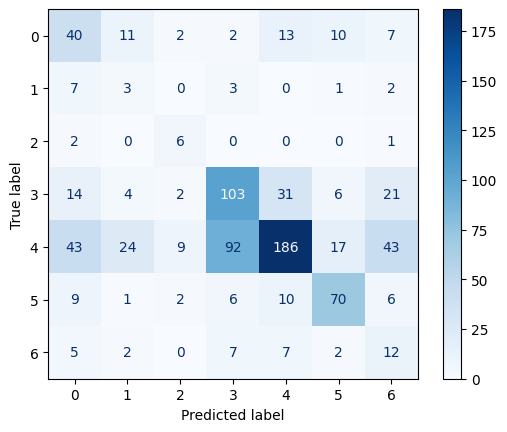

In [40]:
# @title Matriz de confusión en Dev
cm_dev = confusion_matrix(y_dev, y_dev_pred)
ConfusionMatrixDisplay(cm_dev).plot(cmap="Blues")

In [16]:
# @title Reporte de clasificación por emoción
# =============================
# 7. Evaluación en Test final
# =============================
y_test_pred = model_balanced.predict(X_test_vec)
print("==== Evaluación en Test ====")
print(classification_report(y_test, y_test_pred))

==== Evaluación en Test ====
              precision    recall  f1-score   support

       anger       0.10      0.15      0.12       168
     disgust       0.03      0.09      0.05        33
        fear       0.02      0.05      0.02        21
         joy       0.25      0.26      0.25       354
      others       0.50      0.33      0.40       814
     sadness       0.13      0.13      0.13       199
    surprise       0.04      0.10      0.06        67

    accuracy                           0.26      1656
   macro avg       0.15      0.16      0.15      1656
weighted avg       0.33      0.26      0.28      1656



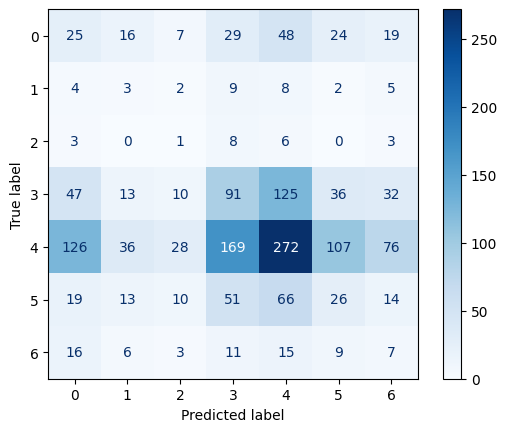

In [41]:
# @title Matriz de confusión en Test
cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm_test).plot(cmap="Blues")

### **Modelo multi-clase con desbalance aceptable y confiable:**
* **F1 macro ≥ 0.60**
* Cada clase logre **precision y recall ≥ 0.60** (sin dejar clases olvidadas).

> *Si logras ≥ 0.70 en F1 macro*, ya se considera robusto y aplicable en entornos prácticos.

##🔎 **Análisis de resultados (Regresión logística + TF-IDF)**

* Precisión baja en clases minoritarias → el modelo favorece la clase mayoritaria.
* Desbalance en dataset → recall y f1-score muestran que las clases poco representadas casi no se predicen.
* Overfitting moderado → training accuracy > validation accuracy.
* Palabras poco discriminativas → TF-IDF no captura bien el contexto semántico.

## 🛠️ **Mejoras sugeridas**

* Balanceo de clases: aplicar oversampling (SMOTE) o class_weight="balanced".
* Optimizar TF-IDF: ajustar ngram_range, max_features y min_df.
* Regularización: tunear parámetro C en Logistic Regression.
* Feature Engineering: probar stopwords, lematización o selección de palabras clave.
* Comparación de modelos: evaluar Naive Bayes y SVM como referencia.
* Validación más robusta: usar cross-validation para resultados más confiables.

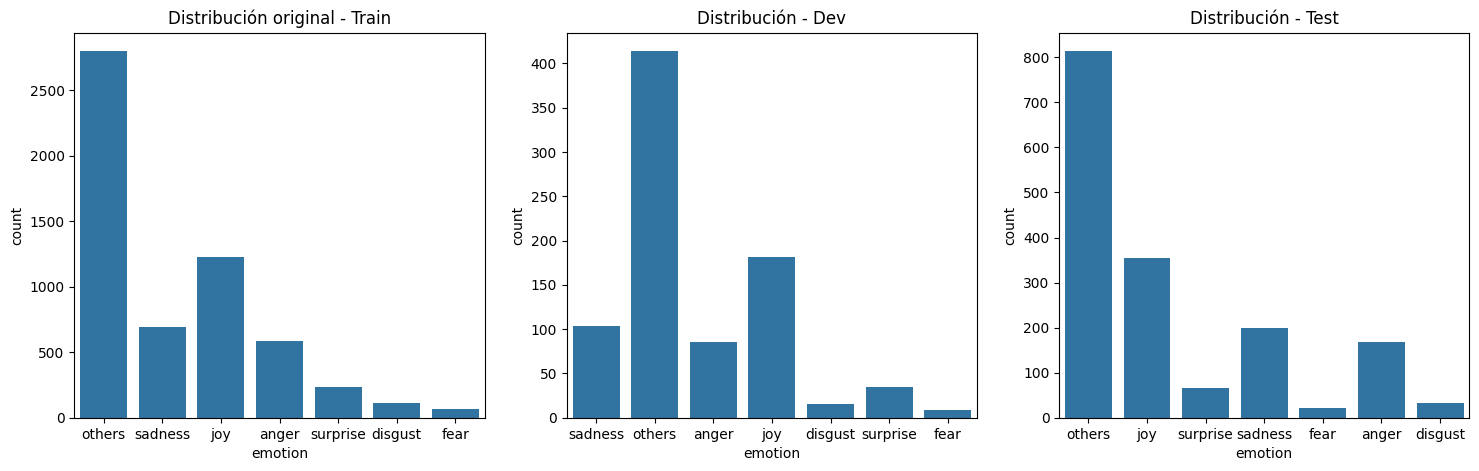

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =============================
# 1. Distribución de clases original (Train, Dev, Test)
# =============================
fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title("Distribución original - Train")

sns.countplot(x=y_dev, ax=axes[1])
axes[1].set_title("Distribución - Dev")

sns.countplot(x=y_test, ax=axes[2])
axes[2].set_title("Distribución - Test")

plt.show()

In [28]:
# =============================
# @title Oversampling con SMOTE
# =============================
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_vec, y_train)

In [29]:
# Modelo sin class_weight porque ya balanceamos con SMOTE
model_smote = LogisticRegression(max_iter=200, solver="lbfgs", multi_class="auto")
model_smote.fit(X_train_res, y_train_res)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=200, multi_class='auto')

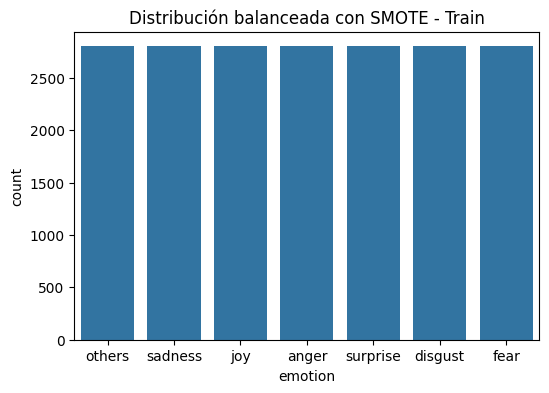

In [30]:
# =============================
# 3. Distribución balanceada en Train
# =============================
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_res)
plt.title("Distribución balanceada con SMOTE - Train")
plt.show()

In [31]:
# =============================
# 6. Evaluación en Dev
# =============================
y_dev_pred_smote = model_smote.predict(X_dev_vec)
print("==== Evaluación en Dev (SMOTE) ====")
print(classification_report(y_dev, y_dev_pred_smote))

==== Evaluación en Dev (SMOTE) ====
              precision    recall  f1-score   support

       anger       0.40      0.55      0.46        85
     disgust       0.12      0.06      0.08        16
        fear       0.86      0.67      0.75         9
         joy       0.52      0.57      0.55       181
      others       0.74      0.62      0.67       414
     sadness       0.65      0.67      0.66       104
    surprise       0.19      0.31      0.23        35

    accuracy                           0.59       844
   macro avg       0.50      0.49      0.49       844
weighted avg       0.61      0.59      0.59       844



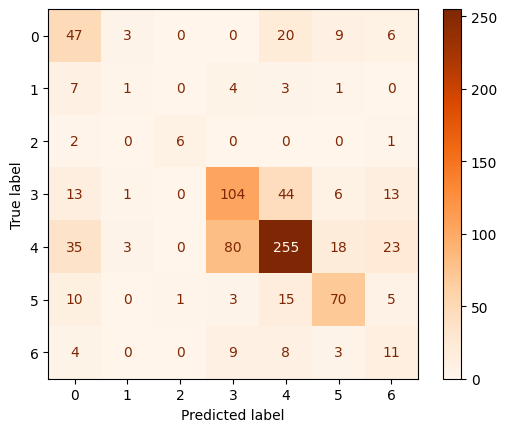

In [43]:
# @title Matriz de confusión en Dev
cm_dev_smote = confusion_matrix(y_dev, y_dev_pred_smote)
ConfusionMatrixDisplay(cm_dev_smote).plot(cmap="Oranges")

In [33]:
# =============================
# 7. Evaluación en Test final
# =============================
y_test_pred_smote = model_smote.predict(X_test_vec)
print("==== Evaluación en Test (SMOTE) ====")
print(classification_report(y_test, y_test_pred_smote))

==== Evaluación en Test (SMOTE) ====
              precision    recall  f1-score   support

       anger       0.11      0.15      0.13       168
     disgust       0.03      0.03      0.03        33
        fear       0.00      0.00      0.00        21
         joy       0.26      0.25      0.25       354
      others       0.50      0.46      0.48       814
     sadness       0.13      0.13      0.13       199
    surprise       0.03      0.04      0.04        67

    accuracy                           0.31      1656
   macro avg       0.15      0.15      0.15      1656
weighted avg       0.33      0.31      0.32      1656



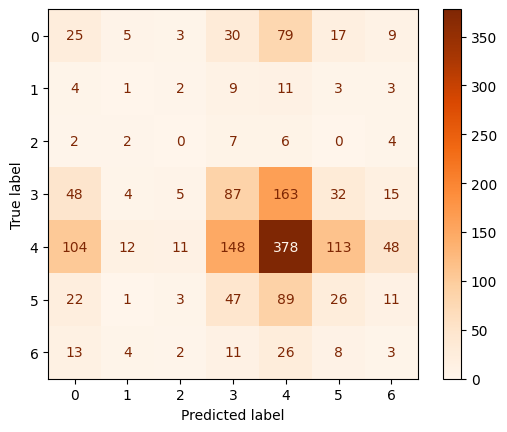

In [44]:
# @title Matriz de confusión (Test)
cm_test_smote = confusion_matrix(y_test, y_test_pred_smote)
ConfusionMatrixDisplay(cm_test_smote).plot(cmap="Oranges")

## **Resultados con class_weight="balanced"**

* Accuracy: 0.26
* F1 macro: 0.15
* Mejores clases: others (0.40 F1) y joy (0.25 F1).
* Varias clases siguen con F1 muy bajo (fear, disgust, surprise).

## **Resultados con SMOTE**

* Accuracy: 0.31 (+0.05, mejora clara).
* F1 macro: 0.15 (similar, no mejora en promedio).
* Others mejora en recall → F1 sube a 0.48 (vs. 0.40).
* Joy se mantiene estable (0.25).
* Fear se cae a 0.00 (pierde completamente).
* Otras minoritarias (disgust, surprise) apenas mejoran o empeoran.

### ✅ **Conclusión**
> **SMOTE mejora la accuracy global** (0.26 → 0.31) gracias a mejor desempeño en la clase mayoritaria (others).
Pero no mejora el macro-F1 (balance entre clases), porque sigue sin aprender bien las minoritarias (incluso fear cae a 0).

> * *Mejor para accuracy (dataset balanceado hacia la mayoría).*

> **class_weight mantiene** un poco más de señal en minoritarias, aunque globalmente tiene menor accuracy.

> * *Más justo con clases minoritarias, aunque con menor rendimiento global.*

In [46]:
# ================================
# @title Evaluación por evento (Dev)
# ================================
df_dev_results = pd.DataFrame({
    "Texto": X_dev,  # tu lista de frases originales
    "Real": y_dev,
    "Predicho_class_weight": y_dev_pred,
    "Predicho_SMOTE": y_dev_pred_smote
})

# Mostrar ejemplos de errores
errores_class_weight = df_dev_results[df_dev_results["Real"] != df_dev_results["Predicho_class_weight"]]
errores_smote = df_dev_results[df_dev_results["Real"] != df_dev_results["Predicho_SMOTE"]]

print("=== Ejemplos de errores (class_weight) ===")
print(errores_class_weight.sample(10))  # muestras aleatorias de errores
print("\n=== Ejemplos de errores (SMOTE) ===")
print(errores_smote.sample(10))

=== Ejemplos de errores (class_weight) ===
                                                 Texto     Real  \
350  Si matan otro dragón yo dejo de ver esta mierd...    anger   
79   #Messi come solo en su mesita en el sofa... va...   others   
392  En ocasiones de gol deben estar ahí, bien pare...   others   
287   USER “Este es el corrupto, ilegítimo régimen ...  disgust   
751  #LibroFavorito de autor chileno "El obsceno pá...      joy   
817   USER USER Madre mía! Solo ver el Gif ya me ha...   others   
372  #ElecccionesGenerales28A tenemos lo que nos me...  sadness   
267  Hasta que no haya 3 millones de parados más (2...  sadness   
700  Quién crees que va a morirá esta noche? Espera...   others   
415  Las cosas claras, NOTRE DAME la a quemado el d...   others   

    Predicho_class_weight Predicho_SMOTE  
350              surprise       surprise  
79                  anger         others  
392                   joy            joy  
287                 anger          anger  
751 

In [ ]:
# ================================
# @title Evaluación por evento (Dev)
# ================================
df_dev_results = pd.DataFrame({
    "Texto": X_dev,  # tu lista de frases originales
    "Real": y_dev,
    "Predicho_class_weight": y_dev_pred,
    "Predicho_SMOTE": y_dev_pred_smote
})

# Mostrar ejemplos de errores
errores_class_weight = df_dev_results[df_dev_results["Real"] != df_dev_results["Predicho_class_weight"]]
errores_smote = df_dev_results[df_dev_results["Real"] != df_dev_results["Predicho_SMOTE"]]

print("=== Ejemplos de errores (class_weight) ===")
print(errores_class_weight.sample(10))  # muestras aleatorias de errores
print("\n=== Ejemplos de errores (SMOTE) ===")
print(errores_smote.sample(10))

In [49]:
# ================================
# @title Evaluación por evento (Test)
# ================================
df_test_results = pd.DataFrame({
    "Texto": X_test,  # tu lista de frases originales
    "Real": y_test,
    "Predicho_class_weight": y_test_pred,
    "Predicho_SMOTE": y_test_pred_smote
})

# Mostrar ejemplos de errores
errores_class_weight_test = df_test_results[df_test_results["Real"] != df_test_results["Predicho_class_weight"]]
errores_smote_test = df_test_results[df_test_results["Real"] != df_test_results["Predicho_SMOTE"]]

print("=== Ejemplos de errores (class_weight) ===")
print(errores_class_weight_test.sample(10))  # muestras aleatorias de errores
print("\n=== Ejemplos de errores (SMOTE) ===")
print(errores_smote_test.sample(10))

=== Ejemplos de errores (class_weight) ===
                                                  Texto     Real  \
17    Que le pasa abonos tibios como USER que defien...    anger   
159   Igual que sus muros acogieron nuestras voces, ...    anger   
1647                                                     sadness   
993   #Theon es el MVP del tercer episodio de #Juego...   others   
1180  Ni un grado mas, con esta fotografía de 360 gr...    anger   
699   #ElecccionesGenerales28A #EleccionesL6. España...   others   
663   USER ..... Excelente y limpio apoyo en #Champi...  sadness   
912   D1OS El PUTOO amo del fútbol #Messi600 #Messi ...   others   
355   Hoy es el #DiaDelLibro y os traemos nuevos tít...  disgust   
1625  El emocionado discurso de la activista ecologi...      joy   

     Predicho_class_weight Predicho_SMOTE  
17                surprise         others  
159                sadness        sadness  
1647                others         others  
993               surprise      

##🔎 **Observaciones de errores con class_weight**

Confusiones frecuentes:
  * anger ↔ surprise
  * sadness ↔ surprise
  * joy ↔ others

Patrón claro:
* El modelo tiende a “tirar” muchas predicciones hacia surprise y others, incluso cuando el texto refleja claramente emociones negativas (anger, sadness, disgust).

> *Posible causa: el **modelo** está **sobreajustando** a clases frecuentes o ambiguas (others, surprise), porque no logra distinguir las señales lingüísticas más sutiles de emociones minoritarias.*


##🔎 **Observaciones de errores con SMOTE**

Confusiones aún más dispersas:
  *  joy confundida con surprise o others.
  *  anger confundida con disgust o surprise.
  *  sadness confundida con others.

Patrón claro:
* El modelo genera más ruido sintético que claridad real. Termina confundiendo textos evidentes (joy, anger) y diluye el aprendizaje.

> *Posible causa: al **forzar equilibrio** con SMOTE, **el modelo aprendió ejemplos “artificiales”** poco representativos → aumenta recall en clases chicas, pero baja la precisión en las grandes.*


## **Conclusiones comparativas**

* Class_weight → aunque confunde, mantiene un comportamiento más “estable” y predecible. Sus errores se concentran en surprise y others.
* SMOTE → introduce mayor variabilidad y ruido, afectando especialmente clases grandes como joy y others.

En ambos casos, se evidencia que el modelo no logra separar bien emociones negativas (anger, disgust, sadness), probablemente por el solapamiento semántico en el dataset y la simplicidad del modelo TF-IDF + regresión logística.